In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import model_selection
#!pip install xgboost
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)

warnings.filterwarnings('ignore')

## Read Train data

In [2]:
train_home_team_statistics_df = pd.read_csv("https://huggingface.co/datasets/bh2821/soccer_pred/resolve/main/train_home_team_statistics_df.csv", index_col=0)
train_away_team_statistics_df = pd.read_csv("https://huggingface.co/datasets/bh2821/soccer_pred/resolve/main/train_away_team_statistics_df.csv", index_col=0)

train_scores = pd.read_csv('https://huggingface.co/datasets/bh2821/soccer_pred/resolve/main/Y_train.csv', index_col=0)

In [3]:
train_home = train_home_team_statistics_df.iloc[:,2:]
train_away = train_away_team_statistics_df.iloc[:,2:]

train_difference = train_home.to_numpy() - train_away.to_numpy()
train_difference_df = pd.DataFrame(train_difference)
train_difference_df.columns = 'DIFF_' + train_home.columns

train_home.columns = 'HOME_' + train_home.columns
train_away.columns = 'AWAY_' + train_away.columns

train_data =  pd.concat([train_home, train_away, train_difference_df], join='inner',axis=1)
train_scores = train_scores.loc[train_data.index]

train_data = train_data.replace({np.inf:np.nan,-np.inf:np.nan})

In [4]:
train_data

,HOME_TEAM_SHOTS_TOTAL_season_sum,HOME_TEAM_SHOTS_INSIDEBOX_season_sum,HOME_TEAM_SHOTS_OFF_TARGET_season_sum,HOME_TEAM_SHOTS_ON_TARGET_season_sum,HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum,HOME_TEAM_PASSES_season_sum,HOME_TEAM_SUCCESSFUL_PASSES_season_sum,HOME_TEAM_SAVES_season_sum,HOME_TEAM_CORNERS_season_sum,HOME_TEAM_FOULS_season_sum,...,DIFF_TEAM_YELLOWCARDS_5_last_match_std,DIFF_TEAM_REDCARDS_5_last_match_std,DIFF_TEAM_OFFSIDES_5_last_match_std,DIFF_TEAM_ATTACKS_5_last_match_std,DIFF_TEAM_PENALTIES_5_last_match_std,DIFF_TEAM_SUBSTITUTIONS_5_last_match_std,DIFF_TEAM_BALL_SAFE_5_last_match_std,DIFF_TEAM_DANGEROUS_ATTACKS_5_last_match_std,DIFF_TEAM_INJURIES_5_last_match_std,DIFF_TEAM_GOALS_5_last_match_std
0,3.0,2.0,5.0,2.0,1.0,2.0,2.0,5.0,3.0,6.0,...,-2.0,-5.0,2.0,0.0,4.0,0.0,3.0,-1.0,2.0,0.0
1,6.0,8.0,3.0,6.0,5.0,8.0,7.0,10.0,6.0,8.0,...,4.0,0.0,1.0,2.0,2.0,-4.0,-9.0,2.0,3.0,1.0
2,4.0,2.0,5.0,2.0,8.0,1.0,1.0,2.0,2.0,7.0,...,-2.0,-5.0,2.0,-1.0,6.0,-1.0,-1.0,3.0,-7.0,-2.0
3,7.0,5.0,5.0,6.0,6.0,9.0,9.0,2.0,2.0,0.0,...,4.0,0.0,0.0,6.0,8.0,0.0,-1.0,2.0,NaN,4.0
4,3.0,3.0,2.0,3.0,4.0,4.0,3.0,4.0,4.0,7.0,...,0.0,0.0,-2.0,1.0,-1.0,3.0,1.0,2.0,-2.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12298,4.0,2.0,3.0,4.0,7.0,4.0,4.0,3.0,2.0,2.0,...,-1.0,-5.0,2.0,4.0,-6.0,-5.0,-1.0,-1.0,NaN,2.0
12299,4.0,2.0,3.0,1.0,5.0,1.0,1.0,9.0,1.0,10.0,...,-1.0,5.0,5.0,0.0,0.0,0.0,2.0,4.0,-3.0,0.0
12300,4.0,3.0,5.0,3.0,5.0,1.0,1.0,6.0,1.0,8.0,...,-1.0,8.0,-3.0,5.0,0.0,0.0,-3.0,-2.0,-1.0,-2.0
12301,2.0,NaN,1.0,1.0,NaN,NaN,NaN,0.0,4.0,2.0,...,8.0,10.0,NaN,6.0,0.0,0.0,-1.0,1.0,NaN,-1.0


In [5]:
crit = train_data.notna().sum(axis=1) > 390

purified_train_data = train_data[crit]
purified_train_data = purified_train_data.fillna(value=0)

purified_train_scores = train_scores[crit]

### I think we need normalization. Make everything within range of [0, 1]

In [6]:
purified_train_data = purified_train_data / 10

In [7]:
purified_train_data

,HOME_TEAM_SHOTS_TOTAL_season_sum,HOME_TEAM_SHOTS_INSIDEBOX_season_sum,HOME_TEAM_SHOTS_OFF_TARGET_season_sum,HOME_TEAM_SHOTS_ON_TARGET_season_sum,HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum,HOME_TEAM_PASSES_season_sum,HOME_TEAM_SUCCESSFUL_PASSES_season_sum,HOME_TEAM_SAVES_season_sum,HOME_TEAM_CORNERS_season_sum,HOME_TEAM_FOULS_season_sum,...,DIFF_TEAM_YELLOWCARDS_5_last_match_std,DIFF_TEAM_REDCARDS_5_last_match_std,DIFF_TEAM_OFFSIDES_5_last_match_std,DIFF_TEAM_ATTACKS_5_last_match_std,DIFF_TEAM_PENALTIES_5_last_match_std,DIFF_TEAM_SUBSTITUTIONS_5_last_match_std,DIFF_TEAM_BALL_SAFE_5_last_match_std,DIFF_TEAM_DANGEROUS_ATTACKS_5_last_match_std,DIFF_TEAM_INJURIES_5_last_match_std,DIFF_TEAM_GOALS_5_last_match_std
0,0.3,0.2,0.5,0.2,0.1,0.2,0.2,0.5,0.3,0.6,...,-0.2,-0.5,0.2,0.0,0.4,0.0,0.3,-0.1,0.2,0.0
1,0.6,0.8,0.3,0.6,0.5,0.8,0.7,1.0,0.6,0.8,...,0.4,0.0,0.1,0.2,0.2,-0.4,-0.9,0.2,0.3,0.1
2,0.4,0.2,0.5,0.2,0.8,0.1,0.1,0.2,0.2,0.7,...,-0.2,-0.5,0.2,-0.1,0.6,-0.1,-0.1,0.3,-0.7,-0.2
3,0.7,0.5,0.5,0.6,0.6,0.9,0.9,0.2,0.2,0.0,...,0.4,0.0,0.0,0.6,0.8,0.0,-0.1,0.2,0.0,0.4
4,0.3,0.3,0.2,0.3,0.4,0.4,0.3,0.4,0.4,0.7,...,0.0,0.0,-0.2,0.1,-0.1,0.3,0.1,0.2,-0.2,-0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12296,0.0,0.0,0.0,0.0,0.0,0.8,0.8,0.7,0.0,0.3,...,-0.7,-1.0,-0.1,0.0,-0.5,-0.6,0.0,-0.2,-0.4,0.0
12298,0.4,0.2,0.3,0.4,0.7,0.4,0.4,0.3,0.2,0.2,...,-0.1,-0.5,0.2,0.4,-0.6,-0.5,-0.1,-0.1,0.0,0.2
12299,0.4,0.2,0.3,0.1,0.5,0.1,0.1,0.9,0.1,1.0,...,-0.1,0.5,0.5,0.0,0.0,0.0,0.2,0.4,-0.3,0.0
12300,0.4,0.3,0.5,0.3,0.5,0.1,0.1,0.6,0.1,0.8,...,-0.1,0.8,-0.3,0.5,0.0,0.0,-0.3,-0.2,-0.1,-0.2


### Data Augmentation

In [8]:
def data_augmentation(append_on, df, func, name):
    df_new = append_on
    for c in df.columns:
        df_new[c+name] = func(df[c])
    return df_new

In [9]:
auged_train_data = purified_train_data.copy()

In [10]:
auged_train_data = data_augmentation(auged_train_data, (purified_train_data + 2), np.log10, "_log")
auged_train_data = data_augmentation(auged_train_data, (purified_train_data + 0), np.square, "_sqre")

### Show data before modelling

In [11]:
auged_train_data

,HOME_TEAM_SHOTS_TOTAL_season_sum,HOME_TEAM_SHOTS_INSIDEBOX_season_sum,HOME_TEAM_SHOTS_OFF_TARGET_season_sum,HOME_TEAM_SHOTS_ON_TARGET_season_sum,HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum,HOME_TEAM_PASSES_season_sum,HOME_TEAM_SUCCESSFUL_PASSES_season_sum,HOME_TEAM_SAVES_season_sum,HOME_TEAM_CORNERS_season_sum,HOME_TEAM_FOULS_season_sum,...,DIFF_TEAM_YELLOWCARDS_5_last_match_std_sqre,DIFF_TEAM_REDCARDS_5_last_match_std_sqre,DIFF_TEAM_OFFSIDES_5_last_match_std_sqre,DIFF_TEAM_ATTACKS_5_last_match_std_sqre,DIFF_TEAM_PENALTIES_5_last_match_std_sqre,DIFF_TEAM_SUBSTITUTIONS_5_last_match_std_sqre,DIFF_TEAM_BALL_SAFE_5_last_match_std_sqre,DIFF_TEAM_DANGEROUS_ATTACKS_5_last_match_std_sqre,DIFF_TEAM_INJURIES_5_last_match_std_sqre,DIFF_TEAM_GOALS_5_last_match_std_sqre
0,0.3,0.2,0.5,0.2,0.1,0.2,0.2,0.5,0.3,0.6,...,0.04,0.25,0.04,0.00,0.16,0.00,0.09,0.01,0.04,0.00
1,0.6,0.8,0.3,0.6,0.5,0.8,0.7,1.0,0.6,0.8,...,0.16,0.00,0.01,0.04,0.04,0.16,0.81,0.04,0.09,0.01
2,0.4,0.2,0.5,0.2,0.8,0.1,0.1,0.2,0.2,0.7,...,0.04,0.25,0.04,0.01,0.36,0.01,0.01,0.09,0.49,0.04
3,0.7,0.5,0.5,0.6,0.6,0.9,0.9,0.2,0.2,0.0,...,0.16,0.00,0.00,0.36,0.64,0.00,0.01,0.04,0.00,0.16
4,0.3,0.3,0.2,0.3,0.4,0.4,0.3,0.4,0.4,0.7,...,0.00,0.00,0.04,0.01,0.01,0.09,0.01,0.04,0.04,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12296,0.0,0.0,0.0,0.0,0.0,0.8,0.8,0.7,0.0,0.3,...,0.49,1.00,0.01,0.00,0.25,0.36,0.00,0.04,0.16,0.00
12298,0.4,0.2,0.3,0.4,0.7,0.4,0.4,0.3,0.2,0.2,...,0.01,0.25,0.04,0.16,0.36,0.25,0.01,0.01,0.00,0.04
12299,0.4,0.2,0.3,0.1,0.5,0.1,0.1,0.9,0.1,1.0,...,0.01,0.25,0.25,0.00,0.00,0.00,0.04,0.16,0.09,0.00
12300,0.4,0.3,0.5,0.3,0.5,0.1,0.1,0.6,0.1,0.8,...,0.01,0.64,0.09,0.25,0.00,0.00,0.09,0.04,0.01,0.04


In [12]:
purified_train_scores

,HOME_WINS,DRAW,AWAY_WINS
0,0,0,1
1,0,1,0
2,0,0,1
3,1,0,0
4,0,1,0
...,...,...,...
12296,1,0,0
12298,0,0,1
12299,0,0,1
12300,0,0,1


In [13]:
purified_train_scores.sum(axis=0)

,0
HOME_WINS,4546
DRAW,2709
AWAY_WINS,3181


## Benchmark

We try to model everything in a -1,0,1 scheme

In [14]:
train_new_y = purified_train_scores["HOME_WINS"] - purified_train_scores["AWAY_WINS"]

Convert to 0, 1, 2 scheme for xgboost

In [15]:
train_new_y = train_new_y + 1

### train, valid test split

In [16]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(auged_train_data, train_new_y, train_size=0.8, random_state=2821)
X_train_mt, X_test_mt, y_train_mt, y_test_mt = model_selection.train_test_split(auged_train_data, purified_train_scores, train_size=0.8, random_state=2821)


### xgb model

In [17]:
params_best = {
    "objective": "multi:softprob",  # Use softmax for multi-class classification
    "num_class": 3,                 # Adjust this to the number of classes in your problem
    "booster": "gbtree",
    "tree_method": "hist",
    "max_depth": 16,                # Maximum tree depth for base learners
    "learning_rate": 0.01,          # Step size shrinkage
    "min_child_weight": 0.8,        # Minimum sum of instance weight needed in a child
    "subsample": 0.8,               # Subsample ratio of the training instance
    "colsample_bytree": 0.8,        # Subsample ratio of columns when constructing each tree
    "gamma": 0.1,                   # Minimum loss reduction required to make a further partition
    "reg_alpha": 0.1,               # L1 regularization term on weights
    "reg_lambda": 1.0,              # L2 regularization term on weights
    "seed": 2821,                   # Random seed for reproducibility
    "verbosity": 1,                 # Verbosity of printing messages
    "nthread": 4                    # Number of threads to use
}
# 50.48% acc

In [18]:
# Bayes search updated best hyperparameters

base_params = {
    "objective":       "multi:softprob",
    "num_class":       3,
    "booster":         "gbtree",
    "tree_method":     "hist",
    "max_depth":       4,
    "learning_rate":   0.016461625366154756,
    "min_child_weight":1,
    "subsample":       0.7191392507460628,
    "colsample_bytree":0.5,
    "gamma":           0.0,
    "reg_alpha":       0.11665044509092395,
    "reg_lambda":      0.05480233318871612,
    "seed":            2821,
    "verbosity":       1,
    "nthread":         4
}


Seed 1000 Confusion Matrix:
[[286   5 325]
 [151   7 383]
 [154   9 768]]


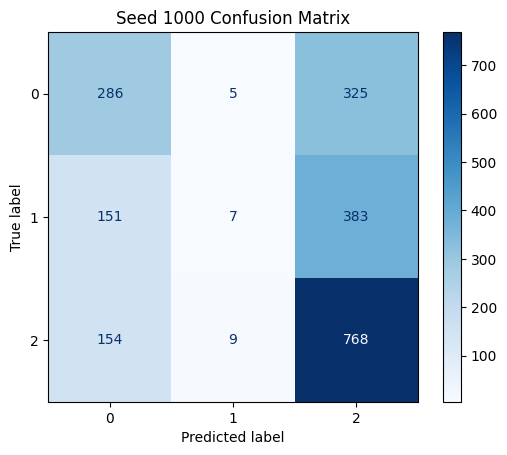

Seed 1001 Confusion Matrix:
[[281   9 326]
 [155   5 381]
 [154   8 769]]


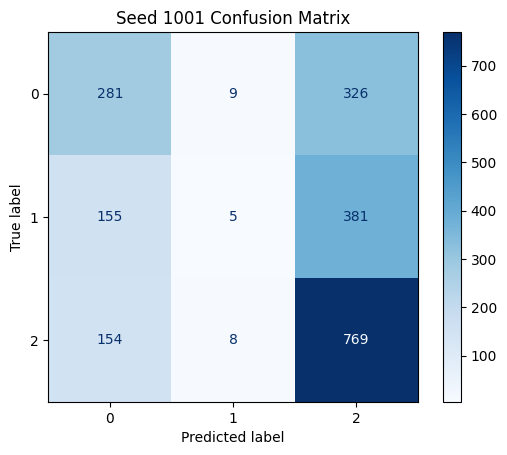

Seed 1002 Confusion Matrix:
[[277   8 331]
 [157  13 371]
 [155  15 761]]


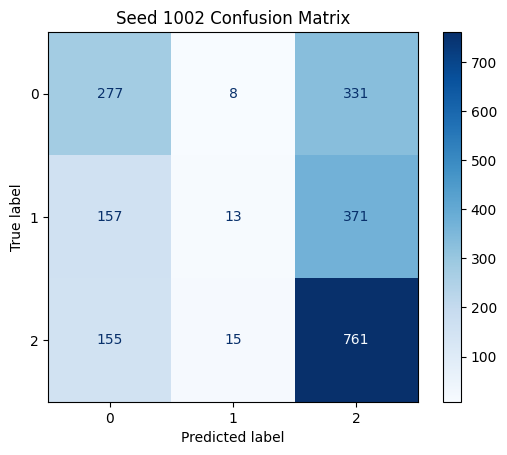

Seed 1003 Confusion Matrix:
[[284   4 328]
 [164   6 371]
 [160   5 766]]


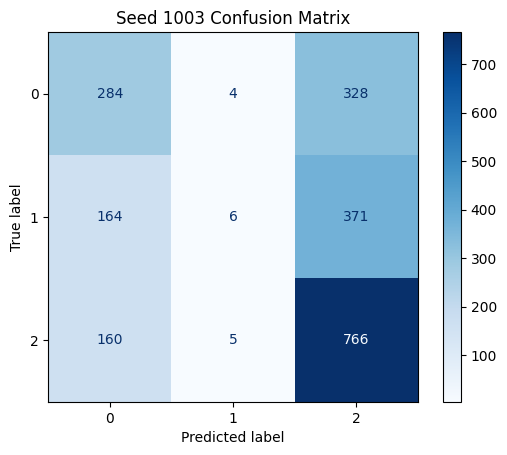

Seed 1004 Confusion Matrix:
[[283   5 328]
 [156   8 377]
 [153   8 770]]


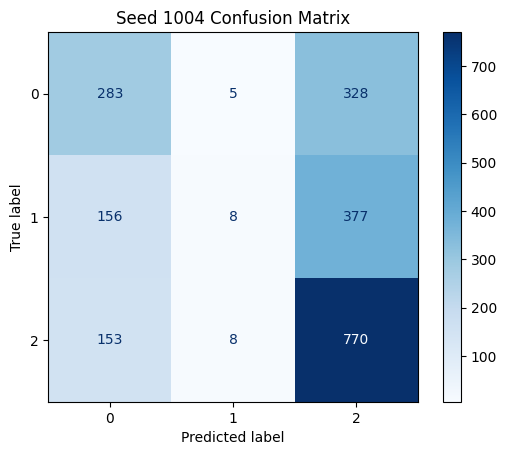

Seed 1005 Confusion Matrix:
[[278   7 331]
 [150   5 386]
 [153   9 769]]


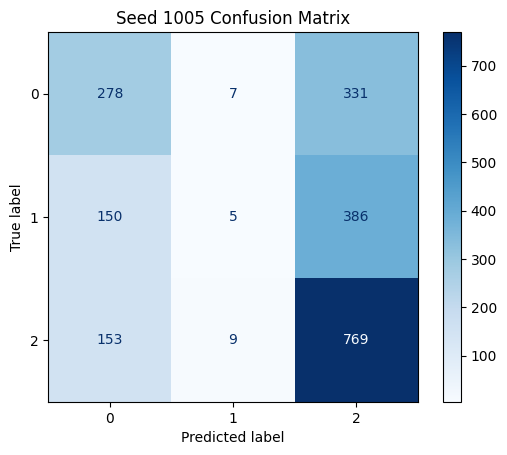

Seed 1006 Confusion Matrix:
[[278   5 333]
 [156   7 378]
 [156   7 768]]


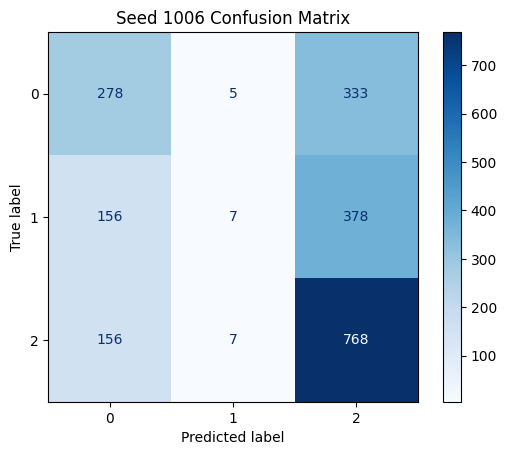

Seed 1007 Confusion Matrix:
[[283   6 327]
 [154   7 380]
 [152  12 767]]


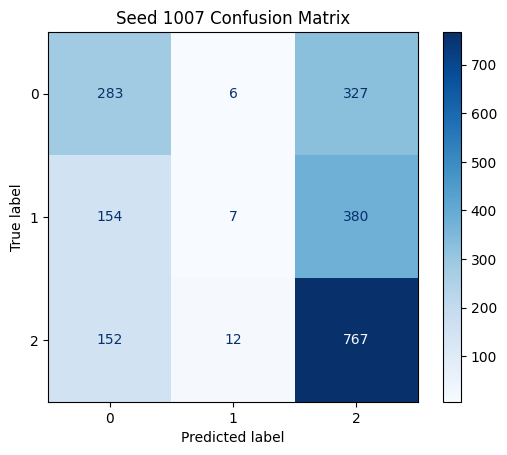

Seed 1008 Confusion Matrix:
[[287   4 325]
 [158   6 377]
 [157   9 765]]


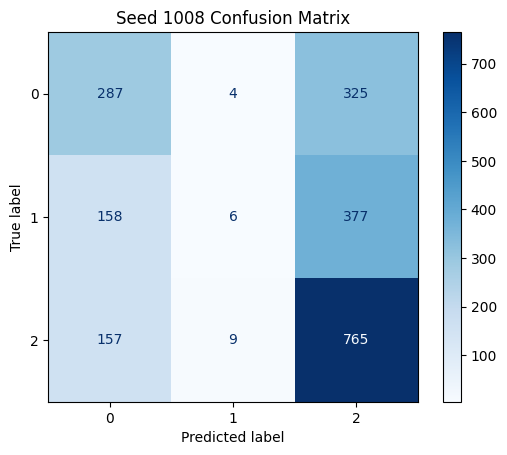

Seed 1009 Confusion Matrix:
[[287   2 327]
 [156   5 380]
 [149  11 771]]


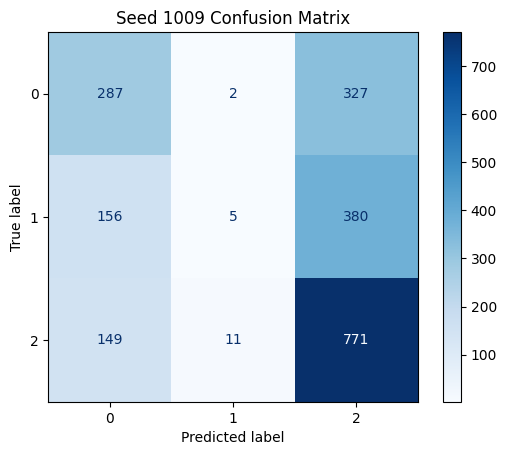

=== 10 Seeds Evaluation Result ===
Accuracy: mean=0.5061, std=0.0019
Precision: mean=0.4553, std=0.0144
Recall: mean=0.5061, std=0.0019
F1 Score: mean=0.4288, std=0.0019


In [19]:
seeds = list(range(1000, 1010))
accs, precs, recs, f1s = [], [], [], []

d_train = xgb.DMatrix(X_train.replace({0: np.nan}), label=y_train)
d_test  = xgb.DMatrix(X_test.replace({0: np.nan}),  label=y_test)

for seed in seeds:
    params = base_params.copy()
    params['seed'] = seed

    bst_0 = xgb.train(
        params,
        d_train,
        num_boost_round=10000,
        evals=[(d_train, 'train'), (d_test, 'eval')],
        early_stopping_rounds=1,
        verbose_eval=False
    )

    params["learning_rate"] = 0.02

    bst = xgb.train(
        params,
        d_train,
        num_boost_round=10000,
        evals=[(d_train, 'train'), (d_test, 'eval')],
        xgb_model=bst_0,
        early_stopping_rounds=2,
        verbose_eval=False
    )

    y_prob = bst.predict(d_test)
    y_pred = np.argmax(y_prob, axis=1)
    y_true = y_test

    accs.append(accuracy_score(y_true, y_pred))
    precs.append(precision_score(y_true, y_pred, average='weighted', zero_division=0))
    recs.append(recall_score(y_true, y_pred, average='weighted', zero_division=0))
    f1s.append(f1_score(y_true, y_pred, average='weighted', zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    print(f"Seed {seed} Confusion Matrix:\n{cm}")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Seed {seed} Confusion Matrix")
    plt.show()

print("=== 10 Seeds Evaluation Result ===")
print(f"Accuracy: mean={np.mean(accs):.4f}, std={np.std(accs):.4f}")
print(f"Precision: mean={np.mean(precs):.4f}, std={np.std(precs):.4f}")
print(f"Recall: mean={np.mean(recs):.4f}, std={np.std(recs):.4f}")
print(f"F1 Score: mean={np.mean(f1s):.4f}, std={np.std(f1s):.4f}")

# === 10 Seeds Evaluation Result ===
# Accuracy: mean=0.5033, std=0.0036
# Precision: mean=0.4590, std=0.0099
# Recall: mean=0.5033, std=0.0036
# F1 Score: mean=0.4424, std=0.0044

# === 10 Seeds Evaluation Result ===
# Accuracy: mean=0.5061, std=0.0019
# Precision: mean=0.4553, std=0.0144
# Recall: mean=0.5061, std=0.0019
# F1 Score: mean=0.4288, std=0.0019
